# Contrast curves

In [1]:
cd /home

/home


In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from core.metrics import inject_companion, get_rings, get_throughput, get_aperture_photometry, get_contrast
from core.data import load_data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
datapath ='./data/HCI/'
predlogs = './logs/HCI/'

cube, psfs, rot_angles = load_data(datapath)

params_table = pd.read_csv(os.path.join(predlogs, 'prediction.csv'))

row = params_table.iloc[0]
pixel = 0.01225
cube = cube[0] # single wavelength
psfs = psfs[0] # single wavelength

print(psfs.shape, cube.shape)
params_table

[INFO] channels:  [0 1]
New shape: (2, 63, 63)
`Size` is even (while input frame size is odd). Setting `size` to 31 pixels
(2, 90, 201, 201)
New shape: (2, 63, 63)
`Size` is even (while input frame size is odd). Setting `size` to 31 pixels
(2, 63, 63) (90, 201, 201)


,index,x,y,flux,fwhm_mean,snr,optimal_flux,optimal_x,optimal_y
0,1,90.979735,87.349373,31.502242,4.559094,4.930585,43.777077,90.98452,87.34764


## step 1: Cleaning cube dataset

In [9]:
cube_center = cube.shape[-1]/2

radius = np.sqrt((-cube_center)**2+(row['optimal_y']-cube_center)**2)

injected = inject_companion(row['optimal_x'], 
                            row['optimal_y'], 
                            row['optimal_flux'],
                            cube=np.zeros_like(cube),
                            psf=psfs[0],
                            rot_angles=rot_angles)

Branch 1:
	(X,Y)=(90.48, 86.85) at 0.20 arcsec (16.23 pxs from center)


In [10]:
clean_cube = cube - injected # subtract the planet

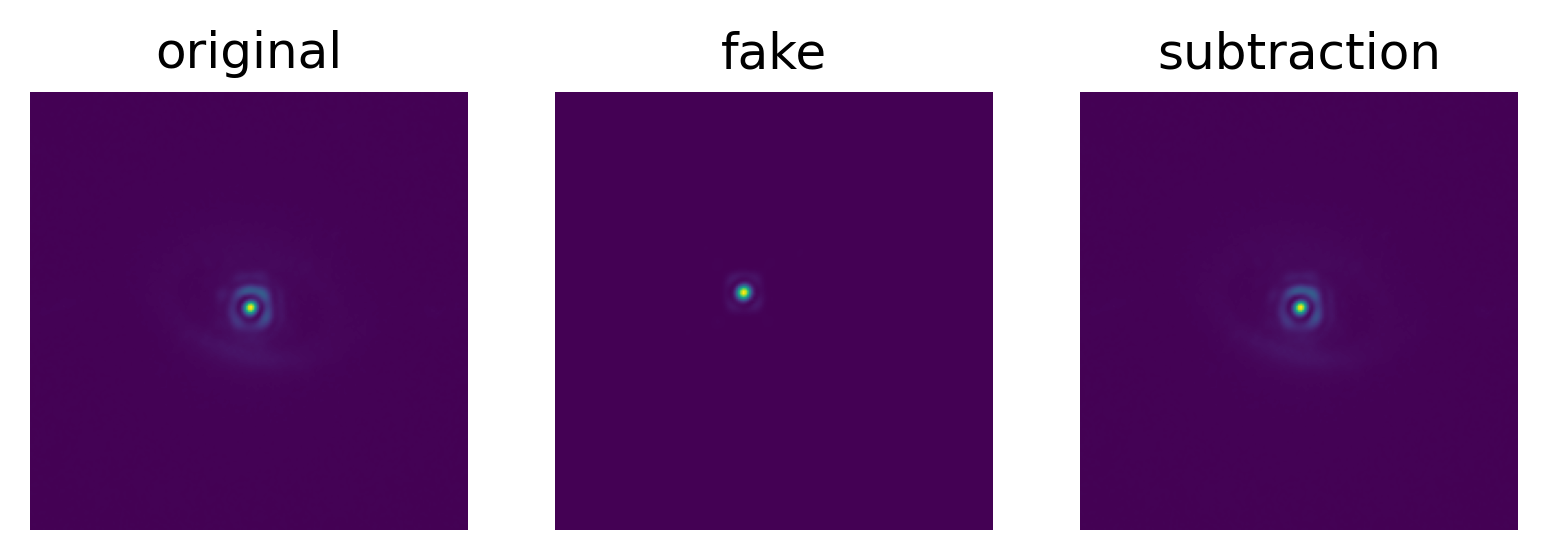

In [11]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(cube[0], origin='lower')
axes[1].imshow(injected[0], origin='lower')
axes[2].imshow(clean_cube[0], origin='lower')

for ax, title in zip(axes, ['original', 'fake', 'subtraction']):
    ax.axis('off')
#     ax.set_xlim(row['optimal_x']-40, row['optimal_x']+40)
#     ax.set_ylim(row['optimal_y']-20, row['optimal_y']+50)
    ax.set_title(title)

## step 2: Draw rings FWHM-diameter apertures

In [12]:
nframes, width, height = cube.shape
max_boundary = width * 0.5
num_rings =  20

regions, rad_dist_px = get_rings(row['optimal_x'], row['optimal_y'], 
                                 fhwm=row['fwhm_mean'],
                                 cube=clean_cube, 
                                 rot_angles=rot_angles,
                                 num_rings=num_rings)

2023-08-16 19:06:46.516529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 19:06:46.577037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 19:06:46.595808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To ena

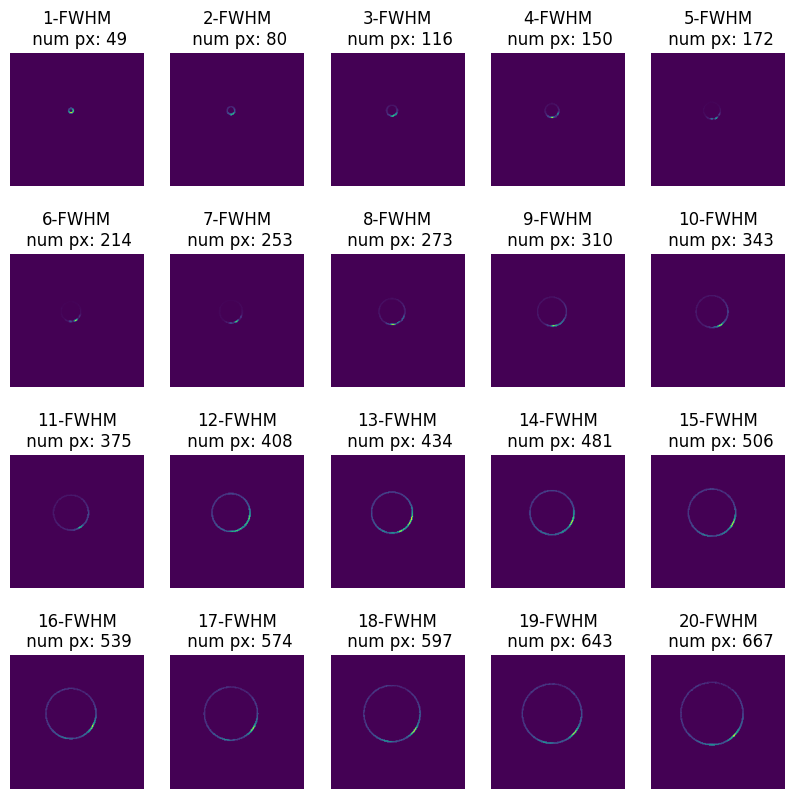

In [13]:
fig, axes = plt.subplots(4, 5, figsize=(10,10))
axes = axes.flatten()
for i in range(1, 21):
    N = np.sum(regions[i-1][0]!=0.)
    axes[i-1].imshow(regions[i-1][0])
    axes[i-1].axis('off')
    axes[i-1].set_title('{}-FWHM\n num px: {}'.format(i, N))

## step 3: Find the fraction of resolution element whose sum exceeds the detection threshold

In [50]:
ap_phot = get_aperture_photometry(psfs, 
                                  fwhm=row['fwhm_mean']) # Should be star;s phot
ap_phot

0.8271414287810099

In [55]:
from photutils.aperture import aperture_photometry, CircularAperture
aper = CircularAperture((cube.shape[1]/2, cube.shape[2]/2), 
                        r=row['fwhm_mean'] / 2.) 
obj_flux_i = aperture_photometry(cube[0], aper, method='exact')
ap_phot = obj_flux_i['aperture_sum'][0]
ap_phot

2058.8747501463145

In [56]:
contrast = get_contrast(regions, ap_phot, factor=5)

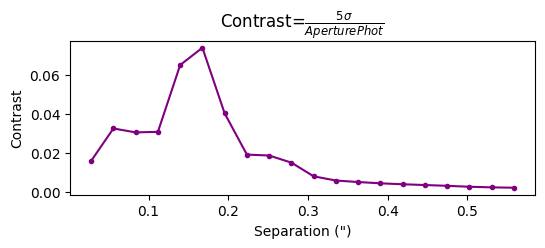

In [114]:
import matplotlib.ticker as ticker
x_range = np.arange(1, 21, 1)
plt.figure(figsize=(6, 2))

plt.plot(rad_dist_px*0.01225, contrast, marker='.', color='purple')
plt.ylabel(r'Contrast')
plt.xlabel('Separation (")')
plt.title(r'Contrast=$\frac{5\sigma}{AperturePhot}$')
plt.show()

## step 4: Estimate the algorithm throughput 

In [73]:
%%time
throughput, opt_summary = get_throughput(
                        clean_cube, 
                        psfs, 
                        rot_angles,
                        fwhm=row['fwhm_mean'],
                        rad_distances=rad_dist_px,
                        regions=regions,
                        K=1,
                        window_size=10,
                        optimize=True) #  for testing, if False it uses the optimal parameter to calculate ratios

[INFO] Training (x, y) = (102.28 100.00)
Branch 1:
	(X,Y)=(102.28, 100.00) at 0.03 arcsec (2.28 pxs from center)
[INFO] Training (x, y) = (104.56 100.00)
Branch 1:
	(X,Y)=(104.57, 100.00) at 0.06 arcsec (4.57 pxs from center)
[INFO] Training (x, y) = (106.84 100.00)
Branch 1:
	(X,Y)=(106.84, 99.99) at 0.08 arcsec (6.84 pxs from center)
[INFO] Training (x, y) = (109.12 100.00)
Branch 1:
	(X,Y)=(109.12, 100.00) at 0.11 arcsec (9.12 pxs from center)
[INFO] Training (x, y) = (111.40 100.00)
Branch 1:
	(X,Y)=(111.40, 100.00) at 0.14 arcsec (11.40 pxs from center)
[INFO] Training (x, y) = (113.68 100.00)
Branch 1:
	(X,Y)=(113.68, 100.01) at 0.17 arcsec (13.68 pxs from center)
[INFO] Training (x, y) = (115.96 100.00)
Branch 1:
	(X,Y)=(115.96, 100.00) at 0.20 arcsec (15.96 pxs from center)
[INFO] Training (x, y) = (118.24 100.00)
Branch 1:
	(X,Y)=(118.24, 100.00) at 0.22 arcsec (18.24 pxs from center)
[INFO] Training (x, y) = (120.52 100.00)
Branch 1:
	(X,Y)=(120.52, 99.99) at 0.25 arcsec (20.

In [82]:
residuals.shape

(14,)

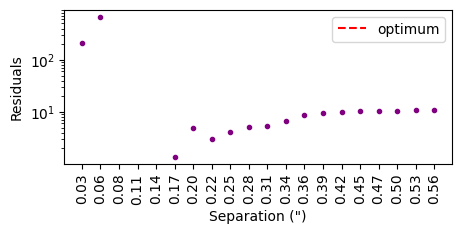

In [115]:
opt_summary_f = opt_summary

true = opt_summary_f['flux']+(clean_cube.std()*3)
pred = opt_summary_f['optimal_flux']
x = opt_summary_f['rad_dist']
residuals = true - pred

plt.figure(figsize=(5,2))
plt.scatter(x, residuals, marker='.', color='purple')
plt.xticks(rad_dist_px, ['{:.2f}'.format(i) for i in rad_dist_px*0.01225],
           rotation=90)
plt.plot(rad_dist_px, np.zeros_like(rad_dist_px), 
         linestyle='--', color='red', label='optimum')
plt.ylabel('Residuals')
plt.xlabel('Separation (")')
plt.legend()
plt.yscale('log')
plt.show()

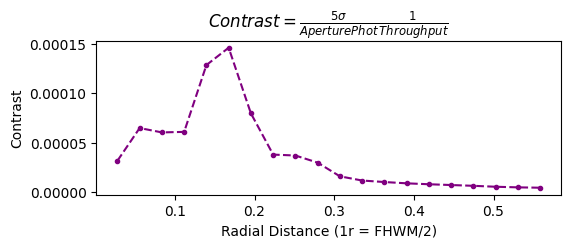

In [95]:
plt.figure(figsize=(6, 2))
plt.plot(rad_dist_px*0.01225, np.array(contrast)*throughput, marker='.', linestyle='--', color='purple')
plt.ylabel(r'Contrast')
plt.xlabel('Radial Distance (1r = FHWM/2)')
plt.title(r'$Contrast=\frac{5\sigma}{AperturePhot} \frac{1}{Throughput}$')
plt.show()

## step 5: Correct for small samples 

At small angles small samples (pixels) are considered. For this reason we need a correction factor to the empirical standard deviation. 

From [Mawet et.al., 2014](https://arxiv.org/pdf/1407.2247.pdf) the corrector factor can be derived from a **two-test t-student test** where:
- H0: Signal absent 
- H1: Signal present
 
Under the null hypothesis we want to verify if a single pixel was drawn from a parent population of spekles, with an unknown but common variance $\sigma^2(r)$. By re-arranging (*see Mawet et.al., 2014 Section 3.2*)  the t-test for unqual samples sizes, equal variance, we obtain: 
  
$p_t(x, n_2) = \frac{\bar{x_1}-\bar{x_2}}{s_2\sqrt{1+\frac{1}{n_2}}}$ (1)
  
where $\bar{x}_1$ is the intenisty of single element, and $\bar{x}_2$ is the average intensity over the remaining $n_2=n_{ring}-1$ pixels, and $p_t$ is the t-student distribution with $n_2$ DOF (Degrees of Freedom).

Equation (1) is similar to SNR except for the $\sqrt{1+\frac{1}{n_2}}$ correction factor. Notice when $n_2 >> 1$ large samples the correction factor converge to 1, and the t-distribution converges to the normal distribution.

By using the correction factor on our definition of contrast, 

$\text{Contrast} = \frac{\tau\sigma\sqrt{1+\frac{1}{n_2}}}{\text{Aperture Phot}}$

Where $\tau$ the detection threshold is given by the Percent point (inverse CDF) function of the Student T distribution with $n_2$ DOF (see [Rebecca Jensen-Clem et.al., 2017 Section 5.1](https://iopscience.iop.org/article/10.3847/1538-3881/aa97e4/pdf)).

In [104]:
from core.metrics import correct_contrast

In [105]:
corr_contrast = correct_contrast(contrast, regions, ap_phot)

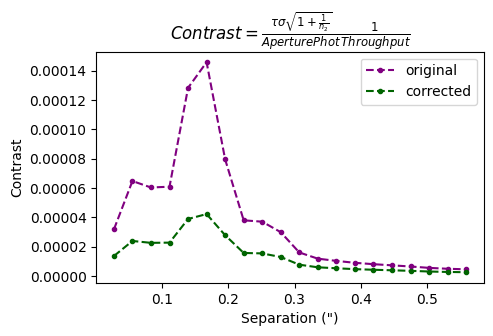

In [113]:
plt.figure(figsize=(5, 3))
plt.plot(rad_dist_px*0.01225, np.array(contrast)*throughput, 
         marker='.', linestyle='--', color='purple', label='original')
plt.plot(rad_dist_px*0.01225, np.array(corr_contrast)*throughput, 
         marker='.', linestyle='--', color='darkgreen', label='corrected')
plt.ylabel(r'Contrast')
plt.xlabel('Separation (")')
plt.title(r'$Contrast=\frac{\tau\sigma\sqrt{1+\frac{1}{n_2}}}{AperturePhot} \frac{1}{Throughput}$')
plt.legend()
plt.show()